In [1]:
import numpy as np
import cv2
import os
import re
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras import layers, Model
import zipfile
import re
import random
from itertools import combinations
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tabulate import tabulate

In [2]:
zip_path = "fingerprint_bitmaps.zip"
extract_path = "fingerprint_bitmaps"

In [3]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully.")

Dataset extracted successfully.


In [4]:
def preprocess_image(img):
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.equalizeHist(img)
    img = img.astype(np.float32) / 255.0
    img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    return img

In [5]:
def extract_label(filename):
    match = re.match(r"(\d+)_\d+", filename)
    return int(match.group(1)) if match else None

def load_images(folder_path):
    images, labels = [], []
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.bmp'):
            img = cv2.imread(os.path.join(folder_path, file), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = preprocess_image(img)
                images.append(img)
                labels.append(extract_label(file))
    return np.array(images), np.array(labels)

In [6]:
images, labels = load_images(extract_path)
print(f"Loaded {len(images)} images | Shape: {images.shape}")
print(f"Unique labels: {np.unique(labels)}")

Loaded 168 images | Shape: (168, 256, 256, 1)
Unique labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [7]:
NUM_CLASSES = 21
DATASET_SIZE = 2000

In [8]:
def generate_dataset(images, labels):
    X = []
    classes = np.unique(labels)
    class_img = []
    class_idx = {}

    for i in range(NUM_CLASSES):
        class_img += [(labels == classes[i]).nonzero()[0]]
        class_idx[classes[i]] = i

    required_iterations = int(DATASET_SIZE / len(images))

    for itr in range(required_iterations):
        for i in range(len(images)):
            # get the anchor
            anchor = images[i]
            anchor_lbl = labels[i]

            # get a positive example
            pos_idx = random.choice(class_img[class_idx[anchor_lbl]])
            positive = images[pos_idx]


            # get a negative example
            different_class = random.randint(0, NUM_CLASSES-1)
            while different_class == class_idx[anchor_lbl]:
                different_class = random.randint(0, NUM_CLASSES-1)

            neg_idx = random.choice(class_img[different_class])
            negative = images[neg_idx]

            X += [[anchor, positive, negative]]

    return np.array(X)

In [9]:
X = generate_dataset(images, labels)

In [10]:
X.shape

(1848, 3, 256, 256, 1)

In [11]:
np.random.RandomState(seed=100).shuffle(X)

In [12]:
train_len = int(0.7 * DATASET_SIZE)
x_train = X[:train_len]
x_test = X[train_len:]

In [13]:
img_shape = x_train[0][0].shape

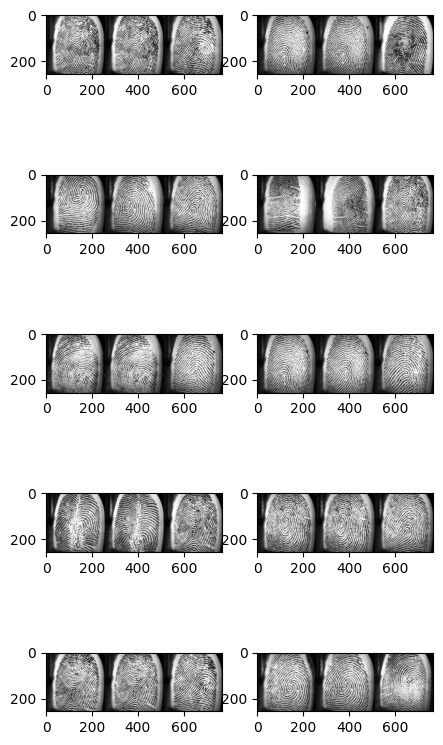

In [14]:
fig, axes = plt.subplots(5, 2, figsize=(5, 10))
for i in range(10):
    ax = axes[i // 2, i % 2]
    img_idx = random.randint(0, len(x_train))
    ax.imshow(keras.ops.concatenate([x_train[img_idx][0], x_train[img_idx][1], x_train[img_idx][2]], axis=1), cmap='gray')

In [15]:
def embedding_network(in_shape):
    input_layer = keras.layers.Input(in_shape)

    x = keras.layers.BatchNormalization()(input_layer)

    x = keras.layers.Conv2D(32, (5, 5), activation="tanh")(x)
    x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)

    x = keras.layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Conv2D(128, (3, 3), activation="relu")(x)
    x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(100, activation="relu")(x)

    m = keras.Model(inputs=input_layer, outputs=x)

    return m

In [16]:
class DistanceLayer(keras.layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [17]:
anchor_input = keras.layers.Input(img_shape, name="anchor")
positive_input = keras.layers.Input(img_shape, name="positive")
negative_input = keras.layers.Input(img_shape, name="negative")

embedding_net_obj = embedding_network(img_shape)

triplet_1 = (embedding_net_obj)(anchor_input)
triplet_2 = (embedding_net_obj)(positive_input)
triplet_3 = (embedding_net_obj)(negative_input)

merge_layer = DistanceLayer()(triplet_1, triplet_2, triplet_3)

complete_layers = keras.Model(inputs=[anchor_input, positive_input, negative_input], outputs=merge_layer)

In [18]:
class SiameseModel(keras.Model):
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)

        loss = ap_distance - an_distance
        loss = keras.ops.maximum(loss + self.margin, 0.0)
        return tf.reduce_mean(loss)

    @property
    def metrics(self):
        return [self.loss_tracker]

In [19]:
siamese_model_1 = SiameseModel(complete_layers, margin=1.0)
siamese_model_1.compile(optimizer=keras.optimizers.Adam(0.001))
siamese_model_1.summary()

Model: "siamese_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)            │ ((None,), (None,))          │      30,091,240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,091,240 (114.79 MB)

 Trainable params: 29,860,838 (113.91 MB)

 Non-trainable params: 230,402 (900.01 KB)

In [20]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = siamese_model_1.fit(
    [x_train[:, 0], x_train[:, 1], x_train[:, 2]],
    validation_data=([x_test[:, 0], x_test[:, 1], x_test[:, 2]]),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['anchor', 'positive', 'negative']
Received: inputs=(('Tensor(shape=(None, 256, 256, 1))', 'Tensor(shape=(None, 256, 256, 1))', 'Tensor(shape=(None, 256, 256, 1))'),)
  warnings.warn(msg)


44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 356ms/step - loss: 0.4047 - val_loss: 0.0370
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - loss: 0.0368 - val_loss: 0.0639
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0548 - val_loss: 0.0683
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0210 - val_loss: 0.0500
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.0236 - val_loss: 0.0468
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - loss: 0.1398 - val_loss: 0.1938


In [21]:
test_loss_m1 = siamese_model_1.evaluate([x_test[:, 0], x_test[:, 1], x_test[:, 2]])
print(f"Test Loss: {test_loss_m1:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['anchor', 'positive', 'negative']
Received: inputs=(('Tensor(shape=(32, 256, 256, 1))', 'Tensor(shape=(32, 256, 256, 1))', 'Tensor(shape=(32, 256, 256, 1))'),)
  warnings.warn(msg)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0334
Test Loss: 0.0370


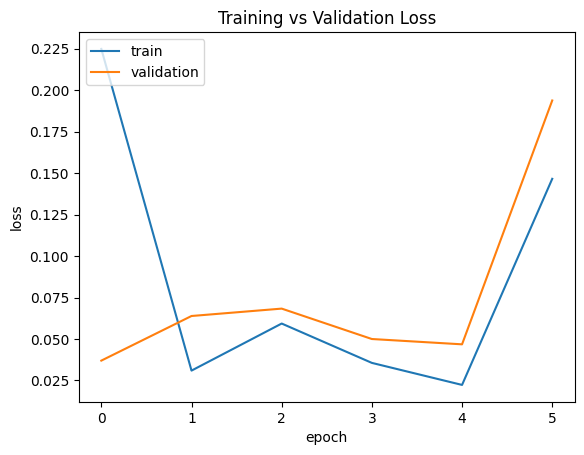

In [22]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "validation"], loc="upper left")
plt.title("Training vs Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

Anchor label: 8
Positive label: 8
Negative label: 20


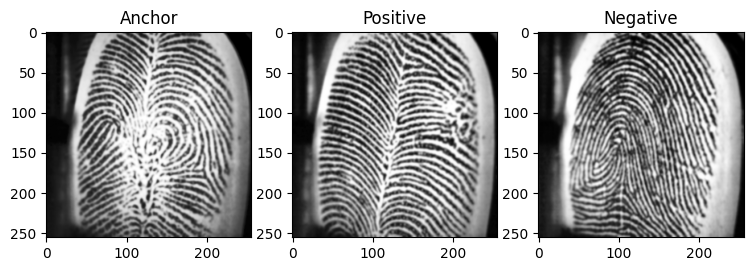

In [23]:
def verify_triplet(anchor, positive, negative, anchor_label, positive_label, negative_label):
    print(f"Anchor label: {anchor_label}")
    print(f"Positive label: {positive_label}")
    print(f"Negative label: {negative_label}")
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.title("Anchor")
    plt.imshow(anchor.squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Positive")
    plt.imshow(positive.squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Negative")
    plt.imshow(negative.squeeze(), cmap='gray')
    plt.show()

sample_idx = random.randint(0, len(x_test) - 1)
anchor, positive, negative = x_test[sample_idx]
anchor_label = labels[np.where((images == anchor).all(axis=(1, 2, 3)))[0][0]]
positive_label = labels[np.where((images == positive).all(axis=(1, 2, 3)))[0][0]]
negative_label = labels[np.where((images == negative).all(axis=(1, 2, 3)))[0][0]]
verify_triplet(anchor, positive, negative, anchor_label, positive_label, negative_label)

In [24]:
predictions = siamese_model_1.predict([x_test[:,0], x_test[:,1], x_test[:,2]])
print(predictions)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
(array([ 3.2815518 ,  0.        ,  0.19199812,  0.96752286,  0.79841244,
        1.8377215 ,  3.3416753 ,  0.5400418 ,  0.39209673,  1.1749086 ,
        1.6218915 ,  0.39517576,  0.6360723 ,  0.34664905,  0.8698905 ,
        0.25110045,  0.61642057,  0.24150297,  0.34664905,  1.7770337 ,
        5.2211385 ,  0.4268614 ,  1.7158004 ,  1.3897164 ,  2.178534  ,
        1.1796285 ,  0.27131265,  0.25110045,  0.        ,  0.8266196 ,
        0.48598456,  0.31160828,  0.33841947,  0.        ,  3.559162  ,
        0.        ,  1.1350371 ,  2.3464472 ,  2.4426904 ,  0.38244697,
        0.22136034,  1.5665476 ,  5.6137414 ,  2.9118843 ,  1.1180041 ,
        0.16376628,  0.34664905,  0.27131265,  0.45011723,  3.0398257 ,
        0.75633854,  1.7136793 ,  0.44751915,  1.3692615 ,  1.1385756 ,
        0.6185434 ,  1.1052878 ,  0.38964513,  2.6073859 ,  0.5400418 ,
        1.6996493 ,  0.32744426,  0.38244697,  1.9613116 ,  0.        ,
        3.2456672 ,  2.

In [25]:
sample = random.choice(x_test)

anchor, positive, negative = sample

anchor_embedding, positive_embedding, negative_embedding = (
    (embedding_net_obj)(np.reshape(anchor,(1,256,256,1))),
    (embedding_net_obj)(np.reshape(positive,(1,256,256,1))),
    (embedding_net_obj)(np.reshape(negative,(1,256,256,1))),
)

In [26]:
def euclidean_distance(embedding1, embedding2):
    return np.linalg.norm(embedding1 - embedding2)

In [27]:
def evaluate_embeddings(embedding_net_obj, x_test, num_samples=10):
    for _ in range(num_samples):
        sample = random.choice(x_test)
        anchor, positive, negative = sample

        anchor_embedding = embedding_net_obj(np.reshape(anchor, (1, 256, 256, 1)))
        positive_embedding = embedding_net_obj(np.reshape(positive, (1, 256, 256, 1)))
        negative_embedding = embedding_net_obj(np.reshape(negative, (1, 256, 256, 1)))

        positive_distance = euclidean_distance(anchor_embedding, positive_embedding)
        negative_distance = euclidean_distance(anchor_embedding, negative_embedding)

        print(f"Positive similarity: {positive_distance}")
        print(f"Negative similarity: {negative_distance}")
        print("-" * 40)

evaluate_embeddings(embedding_net_obj, x_test)

Positive similarity: 0.653343141078949
Negative similarity: 1.6045048236846924
----------------------------------------
Positive similarity: 2.427748441696167
Negative similarity: 4.173847675323486
----------------------------------------
Positive similarity: 0.0
Negative similarity: 2.1718568801879883
----------------------------------------
Positive similarity: 0.7689458727836609
Negative similarity: 1.6921591758728027
----------------------------------------
Positive similarity: 2.3843295574188232
Negative similarity: 2.9415335655212402
----------------------------------------
Positive similarity: 1.1393005847930908
Negative similarity: 4.319385051727295
----------------------------------------
Positive similarity: 0.8651206493377686
Negative similarity: 3.934654951095581
----------------------------------------
Positive similarity: 1.2284321784973145
Negative similarity: 6.5509748458862305
----------------------------------------
Positive similarity: 0.9836271405220032
Negative sim

In [28]:
predictions = siamese_model_1.predict([x_test[:, 0], x_test[:, 1], x_test[:, 2]])
print("Anchor-Positive distances:", predictions[0][:5])  # Print first 5 distances

print("Anchor-Negative distances:", predictions[1][:5])

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Anchor-Positive distances: [3.2815518  0.         0.19199812 0.96752286 0.79841244]
Anchor-Negative distances: [ 6.2267556 18.274784   5.536245  10.5226    54.24012  ]


In [29]:
threshold = np.mean(predictions[0]) + np.std(predictions[0])

In [30]:
def compute_accuracy(model, anchors, positives, negatives, margin=1.0):
    ap_distance, an_distance = model.predict([anchors, positives, negatives])
    accuracy = np.mean(ap_distance + margin < an_distance)
    return accuracy

In [31]:
def compute_precision_recall_f1(model, anchors, positives, negatives, margin=1.0):
    ap_distance, an_distance = model.predict([anchors, positives, negatives])

    # Predictions: 1 if positive pair is closer, 0 otherwise
    y_pred = (ap_distance + margin < an_distance).astype(int)
    y_true = np.ones_like(y_pred)  # All pairs are positive in this setup

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return precision, recall, f1

In [32]:
def compute_roc_auc(model, anchors, positives, negatives):
    # Get distances for positive and negative pairs
    ap_distance, an_distance = model.predict([anchors, positives, negatives])

    # Combine distances into scores
    scores = np.concatenate([-ap_distance, -an_distance])  # Negative distances for positive pairs
    y_true = np.concatenate([np.ones_like(ap_distance), np.zeros_like(an_distance)])

    # Compute ROC-AUC
    roc_auc = roc_auc_score(y_true, scores)
    return roc_auc


In [33]:
def compute_mean_distance_ratio(model, anchors, positives, negatives):
    ap_distance, an_distance = model.predict([anchors, positives, negatives])

    pos_dist = np.mean(ap_distance)
    neg_dist = np.mean(an_distance)

    distance_ratio = pos_dist / neg_dist
    return distance_ratio

In [34]:
def evaluate_model(model, anchors, positives, negatives, margin=1.0):
    # Compute accuracy
    accuracy = compute_accuracy(model, anchors, positives, negatives, margin)

    # Compute precision, recall, and F1-score
    precision, recall, f1 = compute_precision_recall_f1(model, anchors, positives, negatives, margin)

    # Compute ROC-AUC
    roc_auc = compute_roc_auc(model, anchors, positives, negatives)

    # Compute mean distance ratio
    distance_ratio = compute_mean_distance_ratio(model, anchors, positives, negatives)

    # Print results
    print(f"Test Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1-Score: {f1:.2%}")
    print(f"ROC-AUC: {roc_auc:.2%}")
    print(f"Mean Distance Ratio (Positive/Negative): {distance_ratio:.4f}")
    return accuracy, precision, recall, f1, roc_auc, distance_ratio

In [35]:
# Evaluate the model on the test set
accuracy_m1, precision_m1, recall_m1, f1_m1, roc_auc_m1, distance_ratio_m1 = evaluate_model(siamese_model_1, x_test[:, 0], x_test[:, 1], x_test[:, 2])

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Test Accuracy: 95.98%
Precision: 100.00%
Recall: 95.98%
F1-Score: 97.95%
ROC-AUC: 97.07%
Mean Distance Ratio (Positive/Negative): 0.0942


In [36]:
# Step 1: Store user embeddings
def store_user_embeddings(images, labels, embedding_net):
    user_embeddings = {}
    for img, label in zip(images, labels):
        embedding = embedding_net(np.reshape(img, (1, 256, 256, 1)))
        if label not in user_embeddings:
            user_embeddings[label] = []
        user_embeddings[label].append(embedding)

    # Average embeddings for each user
    for label in user_embeddings:
        user_embeddings[label] = np.mean(user_embeddings[label], axis=0)

    return user_embeddings

In [37]:
user_embeddings = store_user_embeddings(images, labels, embedding_net_obj)

In [38]:
# Step 2: Biometric verification
def verify_user(user_id, test_image, user_embeddings, embedding_net, threshold=1.5):
    # Compute embedding for the test image
    test_embedding = embedding_net(np.reshape(test_image, (1, 256, 256, 1)))

    # Retrieve the stored embedding for the claimed user ID
    if user_id not in user_embeddings:
        print(f"User ID {user_id} not found.")
        return False

    stored_embedding = user_embeddings[user_id]

    # Compute Euclidean distance
    distance = np.linalg.norm(test_embedding - stored_embedding)
    print(f"Distance for User ID {user_id}: {distance:.4f}")

    # Verify based on threshold
    if distance < threshold:
        print("Authentication SUCCESS: User verified.")
        return True
    else:
        print("Authentication FAILED: User not verified.")
        return False

In [39]:
# Step 3: Test biometric authentication
def test_authentication(user_embeddings, embedding_net, test_images, test_labels, threshold=1.5):
    for i, (test_image, test_label) in enumerate(zip(test_images, test_labels)):
        print(f"\nTest Case {i + 1}:")
        print(f"True User ID: {test_label}")

        # Correct user ID (should pass)
        print("\nTesting with correct user ID:")
        verify_user(test_label, test_image, user_embeddings, embedding_net, threshold)

        # Incorrect user ID (should fail)
        incorrect_user_id = random.choice([uid for uid in user_embeddings.keys() if uid != test_label])
        print("\nTesting with incorrect user ID:")
        verify_user(incorrect_user_id, test_image, user_embeddings, embedding_net, threshold)

In [40]:
num_test_cases = 5
test_indices = np.random.choice(len(x_test), num_test_cases, replace=False)
test_images = x_test[test_indices, 0]

In [41]:
test_labels = []
for idx in test_indices:
    anchor_image = x_test[idx, 0]

    # Find the index of the anchor image in the original dataset
    anchor_index = np.where((images == anchor_image).all(axis=(1, 2, 3)))[0][0]

    # Retrieve the label for the anchor image
    test_labels.append(labels[anchor_index])

test_labels = np.array(test_labels)

In [42]:
test_authentication(user_embeddings, embedding_net_obj, test_images, test_labels, threshold=threshold)


Test Case 1:
True User ID: 17

Testing with correct user ID:
Distance for User ID 17: 1.8707
Authentication SUCCESS: User verified.

Testing with incorrect user ID:
Distance for User ID 9: 6.2255
Authentication FAILED: User not verified.

Test Case 2:
True User ID: 11

Testing with correct user ID:
Distance for User ID 11: 1.0149
Authentication SUCCESS: User verified.

Testing with incorrect user ID:
Distance for User ID 16: 2.0797
Authentication SUCCESS: User verified.

Test Case 3:
True User ID: 16

Testing with correct user ID:
Distance for User ID 16: 0.4216
Authentication SUCCESS: User verified.

Testing with incorrect user ID:
Distance for User ID 17: 3.5815
Authentication FAILED: User not verified.

Test Case 4:
True User ID: 3

Testing with correct user ID:
Distance for User ID 3: 0.6778
Authentication SUCCESS: User verified.

Testing with incorrect user ID:
Distance for User ID 21: 2.8075
Authentication FAILED: User not verified.

Test Case 5:
True User ID: 15

Testing with c

In [43]:
def generate_pairs(images, labels, num_pairs=4600):
    classes = np.unique(labels)
    class_indices = {cls: np.where(labels == cls)[0] for cls in classes}

    pairs, pair_labels = [], []
    for _ in range(num_pairs):
        # Randomly select a class for the anchor
        anchor_cls = np.random.choice(classes)
        anchor_idx = np.random.choice(class_indices[anchor_cls])

        # Randomly select a positive example (same class)
        pos_idx = np.random.choice(class_indices[anchor_cls])
        while pos_idx == anchor_idx:
            pos_idx = np.random.choice(class_indices[anchor_cls])

        # Randomly select a negative example (different class)
        neg_cls = np.random.choice([cls for cls in classes if cls != anchor_cls])
        neg_idx = np.random.choice(class_indices[neg_cls])

        # Create positive and negative pairs
        pairs.append([images[anchor_idx], images[pos_idx]])  # Positive pair
        pair_labels.append(1)  # Label for positive pair

        pairs.append([images[anchor_idx], images[neg_idx]])  # Negative pair
        pair_labels.append(0)  # Label for negative pair

    return np.array(pairs), np.array(pair_labels)

In [44]:
pairs, pair_labels = generate_pairs(images, labels, DATASET_SIZE)

In [45]:
# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(pairs, pair_labels, test_size=0.3, random_state=42)

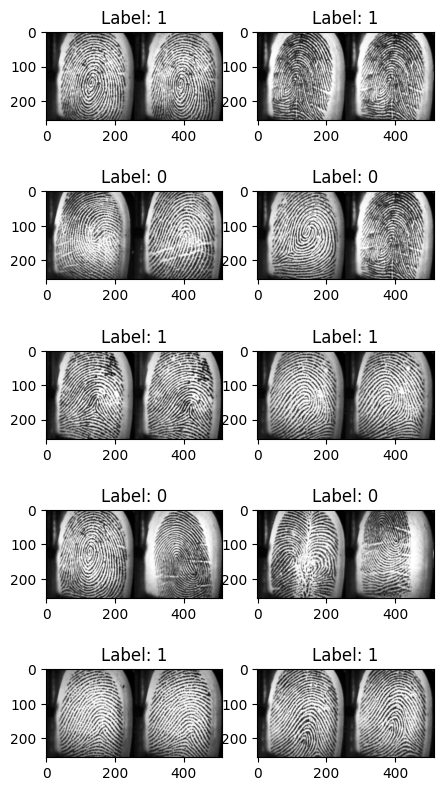

In [46]:
fig, axes = plt.subplots(5, 2, figsize=(5, 10))
for i in range(10):
    ax = axes[i // 2, i % 2]
    img_idx = random.randint(0, len(x_train))
    ax.imshow(keras.ops.concatenate([x_train[img_idx][0], x_train[img_idx][1]], axis=1), cmap='gray')
    ax.set_title("Label: {}".format(y_train[img_idx]))

In [47]:
def siamese_network(input_shape):
    input_a = layers.Input(shape=input_shape, name="input_a")
    input_b = layers.Input(shape=input_shape, name="input_b")


    # Shared embedding network
    embedding_net = keras.Sequential([
        layers.Conv2D(32, (5, 5), activation="tanh", input_shape=input_shape),
        layers.AveragePooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.AveragePooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
    ])

    # Get embeddings for both inputs
    embedding_a = embedding_net(input_a)
    embedding_b = embedding_net(input_b)

    # Compute the absolute difference between embeddings using a Lambda layer
    distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([embedding_a, embedding_b])

    # Output a probability (0 or 1)
    output = layers.Dense(1, activation="sigmoid")(distance)

    return Model(inputs=[input_a, input_b], outputs=output)

In [48]:
# Build the model
input_shape = (256, 256, 1)
siamese_model_2 = siamese_network(input_shape)
siamese_model_2.summary()

# Compile the model with binary cross-entropy loss
siamese_model_2.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_a (InputLayer)      │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_b (InputLayer)      │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128)            │        109,696 │ input_a[0][0],         │
│                           │                        │                │ input_b[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128)            │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │            129 │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 109,825 (429.00 KB)

 Trainable params: 109,825 (429.00 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history = siamese_model_2.fit(
    [x_train[:, 0], x_train[:, 1]],  # Input pairs
    y_train,  # Labels (1 for positive, 0 for negative)
    validation_data=([x_test[:, 0], x_test[:, 1]], y_test),
    batch_size=32,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 0.5214 - loss: 0.6569 - val_accuracy: 0.5333 - val_loss: 0.5660
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.5842 - loss: 0.5359 - val_accuracy: 0.7200 - val_loss: 0.4834
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.7543 - loss: 0.4712 - val_accuracy: 0.7908 - val_loss: 0.4571
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.8018 - loss: 0.4385 - val_accuracy: 0.8092 - val_loss: 0.4029
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.8202 - loss: 0.4032 - val_accuracy: 0.8383 - val_loss: 0.3841
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8500 - loss: 0.3535 - val_accuracy: 0.8867 - val_loss: 0.3491
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.8607 - loss: 0.3364 - val_accuracy: 0.8717 - val_loss: 0.3361
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.8844 - loss: 0.3147 - val_accuracy: 0.8867

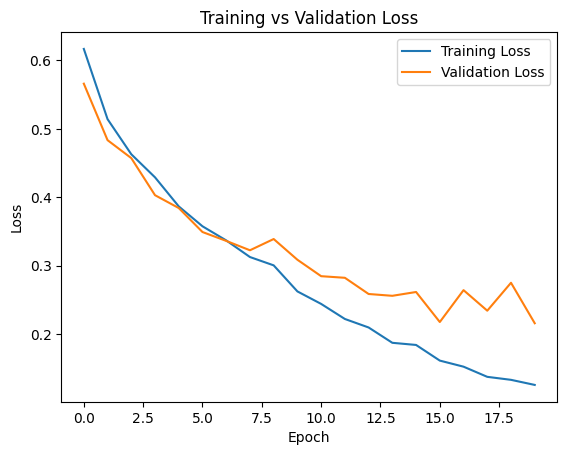

In [50]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [51]:
# Evaluate the model on the test set
test_loss_m2, test_accuracy_m2 = siamese_model_2.evaluate([x_test[:, 0], x_test[:, 1]], y_test)
print(f"Test Loss: {test_loss_m2:.4f}")
print(f"Test Accuracy: {test_accuracy_m2:.2%}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9436 - loss: 0.2341
Test Loss: 0.2157
Test Accuracy: 94.92%


In [52]:
# Make predictions on the test set
y_pred = siamese_model_2.predict([x_test[:, 0], x_test[:, 1]])
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


In [53]:
# Calculate Precision, Recall, F1-Score, and ROC-AUC
precision_m2 = precision_score(y_test, y_pred_binary)
recall_m2 = recall_score(y_test, y_pred_binary)
f1_m2 = f1_score(y_test, y_pred_binary)
roc_auc_m2 = roc_auc_score(y_test, y_pred)


In [54]:
print(f"Loss: {test_loss_m2:.4f}")
print(f"Accuracy: {test_accuracy_m2:.2%}")
print(f"Precision: {precision_m2:.2%}")
print(f"Recall: {recall_m2:.2%}")
print(f"F1-Score: {f1_m2:.2%}")
print(f"ROC-AUC: {roc_auc_m2:.2%}")

Loss: 0.2157
Accuracy: 94.92%
Precision: 95.89%
Recall: 94.19%
F1-Score: 95.04%
ROC-AUC: 97.04%


In [55]:
# Step 1: Store user images (enrollment)
def store_user_images(images, labels):
    user_images = {}
    for img, label in zip(images, labels):
        if label not in user_images:
            user_images[label] = []
        user_images[label].append(img)
    return user_images

# Store images for all users
user_images = store_user_images(images, labels)

In [56]:
def verify_user(user_id, test_image, user_images, siamese_model, threshold=0.5):
    # Retrieve the stored images for the claimed user ID
    if user_id not in user_images:
        print(f"User ID {user_id} not found.")
        return False

    # Compare the test image with all enrolled images of the claimed user
    max_probability = 0
    for enrolled_image in user_images[user_id]:
        # Prepare the input pair (test image and enrolled image)
        pair = np.array([[test_image, enrolled_image]])

        # Predict the similarity probability
        probability = siamese_model.predict([pair[:, 0], pair[:, 1]])[0][0]

        # Track the maximum probability
        if probability > max_probability:
            max_probability = probability

    print(f"Maximum similarity probability for User ID {user_id}: {max_probability:.4f}")

    # Verify based on threshold
    if max_probability > threshold:
        print("Authentication SUCCESS: User verified.")
        return True
    else:
        print("Authentication FAILED: User not verified.")
        return False

In [57]:
test_authentication(user_images, siamese_model_2, test_images, test_labels, threshold=0.5)


Test Case 1:
True User ID: 17

Testing with correct user ID:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Maximum similarity probability for User ID 17: 0.9994
Authentication SUCCESS: User verified.

Testing with incorrect user ID:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Maximum similarity probability for User ID 12: 0.0000
Authentication FAILED: User not verified.

Test Case 2:
True User ID: 11

Testing with correct user ID:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━

In [58]:
from tabulate import tabulate

table = [
    ["Loss", test_loss_m1, test_loss_m2],
    ["Accuracy", f"{accuracy_m1:.2%}", f"{test_accuracy_m2:.2%}"],
    ["Precision", f"{precision_m1:.2%}", f"{precision_m2:.2%}"],
    ["Recall", f"{recall_m1:.2%}", f"{recall_m2:.2%}"],
    ["F1-Score", f"{f1_m1:.2%}", f"{f1_m2:.2%}"],
    ["ROC-AUC", f"{roc_auc_m1:.2%}", f"{roc_auc_m2:.2%}"],
    ["Distance Ratio", distance_ratio_m1, ""]
]

headers = ["Metric", "Model 1", "Model 2"]
print(tabulate(table, headers=headers, tablefmt="grid", floatfmt=".4f"))

+----------------+---------------------+---------------------+
| Metric         | Model 1             | Model 2             |
+================+=====================+=====================+
| Loss           | 0.03695206716656685 | 0.21567901968955994 |
+----------------+---------------------+---------------------+
| Accuracy       | 95.98%              | 94.92%              |
+----------------+---------------------+---------------------+
| Precision      | 100.00%             | 95.89%              |
+----------------+---------------------+---------------------+
| Recall         | 95.98%              | 94.19%              |
+----------------+---------------------+---------------------+
| F1-Score       | 97.95%              | 95.04%              |
+----------------+---------------------+---------------------+
| ROC-AUC        | 97.07%              | 97.04%              |
+----------------+---------------------+---------------------+
| Distance Ratio | 0.09422033280134201 |               